In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree

# Local
import util
import utils


In [2]:
Legacy_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/BG/full_legacy_no_colour_sel/reduced/desi_bg_nomaskbit_mask_4M_reduced_columns.fits"

In [3]:
Gaia_path = "/its/home/bb345/5-4most_data/other_data/gaia_sources/gaia-mask-dr10_bg_foot.fits"

In [4]:
BG = Table.read(Legacy_path)

In [5]:
gaia = Table.read(Gaia_path)

In [6]:
BG = BG.to_pandas()

In [7]:
BG = BG[BG.in_S8]

In [8]:
BG

,OBJID,RA,DEC,EBV,WISEMASK_W1,MASKBITS,isBG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_g,mag_i,mag_w1,isBG_4M_v2,desi_bgs_selection,galactic_cap,dr1_bg_mask
129571,502,61.864164,-48.102204,0.014650,0,0,True,True,False,18.896099,18.056356,20.478117,18.349930,17.650604,True,True,b'SGC',False
129572,1085,61.873766,-48.022694,0.014376,0,0,True,True,False,18.582161,17.871901,19.800209,18.132414,17.555096,True,True,b'SGC',False
129573,1283,61.877416,-47.943971,0.013996,0,65536,False,True,False,19.200485,18.695318,19.976429,18.856028,18.756744,False,True,b'SGC',False
129574,1761,61.885109,-47.882649,0.013249,0,65536,True,True,False,18.683809,18.036644,19.971437,18.269945,17.931900,True,True,b'SGC',False
129575,1848,61.886476,-47.898439,0.013470,0,65536,True,True,False,18.364119,17.642792,19.513239,17.907314,17.596020,True,True,b'SGC',False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722988,4479,221.908058,-21.047307,0.115419,0,0,False,True,False,19.116163,18.171936,20.902779,18.500757,17.514915,True,True,b'NGC',False
16722989,4749,221.919258,-20.909955,0.115234,0,512,False,True,False,19.153049,18.761705,19.777769,18.885019,18.987173,False,True,b'NGC',False
16722990,5960,221.970114,-21.079056,0.114362,0,0,True,True,False,18.919615,18.164978,20.474529,18.426092,17.845531,True,True,b'NGC',False
16722991,6416,221.989764,-20.958015,0.116544,0,2048,False,True,False,17.601774,16.977425,18.500164,17.250980,17.398628,False,True,b'NGC',False


In [9]:
gaia = gaia.to_pandas()

In [10]:
gaia.columns

Index(['RA', 'DEC', 'G', 'R_medium_arcsec', 'R_bright_arcsec', 'isbright',
       'ismedium'],
      dtype='object')

In [11]:
bg = BG

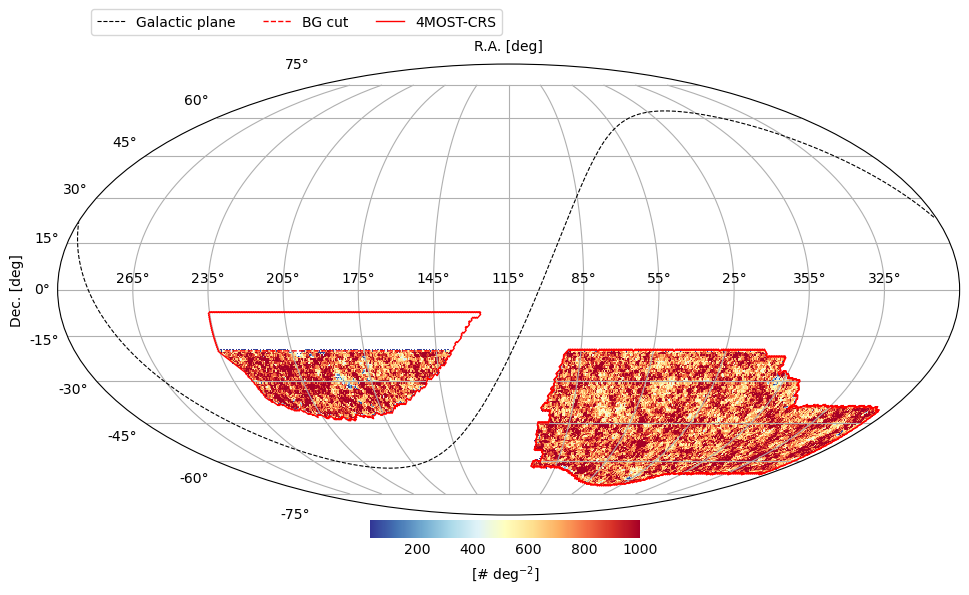

In [13]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

In [16]:
gaia_ra = gaia['RA'].values        # numpy array of RA in deg
gaia_dec = gaia['DEC'].values      # Dec in deg
gaia_mag = gaia['G'].values
gaia_Rmed = gaia['R_medium_arcsec'].values  # in arcsec

bg_ra = bg['RA'].values   # deg
bg_dec = bg['DEC'].values # deg

In [17]:
# Create SkyCoord objects for all Gaia stars and BG sources
gaia_coords = SkyCoord(gaia_ra * u.deg, gaia_dec * u.deg, frame='icrs')
bg_coords   = SkyCoord(bg_ra * u.deg, bg_dec * u.deg, frame='icrs')

In [18]:
Gmin, Gmax = 13, 16

In [19]:
sel = (gaia_mag > Gmin) & (gaia_mag < Gmax)
gaia_coords = gaia_coords[sel]

In [ ]:
R = 0.05 * u.rad

: 

In [ ]:
idx_star, idx_bg, sep2d, _ = gaia_coords.search_around_sky(bg_coords, R)


In [ ]:
# offsets in arcsec
delta_ra  = (BG['ra'][idx_bg]  - gaia['ra'][idx_star]) * np.cos(np.deg2rad(gaia['dec'][idx_star])) * 3600. 
delta_dec = (BG['dec'][idx_bg] - gaia['dec'][idx_star]) * 3600.